In [3]:
import json
import logging

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from captum.attr import Lime, LimeBase
from sklearn.metrics import (
    accuracy_score,
    average_precision_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    confusion_matrix,
)
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm


class CustomDataset(Dataset):
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets

    def __getitem__(self, index):
        x = torch.tensor(self.data.iloc[index, :].values, dtype=torch.float32)
        y = torch.tensor(self.targets.iloc[index], dtype=torch.long)
        return x, y

    def __len__(self):
        return len(self.data)


class Network(nn.Module):
    def __init__(self, input_feats: int = 770) -> None:
        super().__init__()

        self.fc1 = nn.Linear(input_feats, 2**10)
        self.fc2 = nn.Linear(2**10, 2**8)
        self.fc3 = nn.Linear(2**8, 2**5)
        self.fc4 = nn.Linear(2**5, 2**3)
        self.fc5 = nn.Linear(2**3, 2**3)
        self.final = nn.Linear(2**3, 1)
        self.droup_out = nn.Dropout(0.33)

    def forward(self, x):
        x = F.selu(self.fc1(x))
        x = F.selu(self.fc2(x))
        x = self.droup_out(x)
        x = F.selu(self.fc3(x))
        x = self.droup_out(x)
        x = F.selu(self.fc4(x))
        x = F.selu(self.fc5(x))
        x = self.final(x)
        return x

    def predict(self, x):
        with torch.no_grad():
            logits = self.forward(x)
            prob = torch.sigmoid(logits)
            pred = prob > 0.5
        return pred


pth = "./data/master_data_deberta.csv"
master_data = pd.read_csv(pth)
master_data.drop("review", axis=1, inplace=True)
targets = master_data.pop("targets")
X_train, X_test, y_train, y_test = train_test_split(
    master_data, targets, test_size=0.3, stratify=targets
)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.667, stratify=y_test)
print(X_train.shape)
train_dataset = CustomDataset(X_train, y_train)
val_dataset = CustomDataset(X_val, y_val)
test_dataset = CustomDataset(X_test, y_test)

batch_size = 32

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)


(30494, 1026)


In [4]:
model_pth = "./models/best_model_deberta-large.pt"
model = Network(input_feats=1026)
model.load_state_dict(torch.load("./models/best_model_deberta-large.pt"))


<All keys matched successfully>

In [5]:
def evaluate(model, dataloader):
    device = next(model.parameters()).device
    y_true = []
    y_pred = []
    y_score = []
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            logits = model(inputs)
            probs = torch.sigmoid(logits)
            preds = probs > 0.5
            y_true.extend(targets.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            y_score.extend(probs.cpu().numpy())
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average=None)
    precision = precision_score(y_true, y_pred, average=None)
    recall = recall_score(y_true, y_pred, average=None)
    auc = roc_auc_score(y_true, y_score)
    auc_pr = average_precision_score(y_true, y_score)
    metric_dict = {
        "accuracy": acc,
        "f1": f1,
        "precision": precision,
        "recall": recall,
        "auc": auc,
        "auc_pr": auc_pr,
    }
    cm = confusion_matrix(y_true, y_pred)
    return metric_dict, cm


In [13]:
metrics, cm = evaluate(model, test_dataloader)
metrics


{'accuracy': 0.8842624455150264,
 'f1': array([0.84639976, 0.90715009]),
 'precision': array([0.87863464, 0.88746849]),
 'recall': array([0.8164464 , 0.92772445]),
 'auc': 0.9510327506879892,
 'auc_pr': 0.9671397125812947}

In [15]:
cm


array([[2780,  625],
       [ 384, 4929]])

In [5]:
miss_classified = {}
right_classified = {}
model.eval()
with torch.no_grad():
    for data, label in test_dataloader:
        preds = model.predict(data)
        for i in range(len(label)):
            if preds[i] != label[i]:
                # Add the misclassified sample to the dictionary
                miss_classified[i] = {"data": data[i], "label": label[i], "prediction": preds[i]}
            else:
                # Add the correctly classified sample to the dictionary
                right_classified[i] = {"data": data[i], "label": label[i], "prediction": preds[i]}


In [18]:
import random

miss_classified_samples = random.sample(list(miss_classified.values()), k=10)
right_classified_samples = random.sample(list(right_classified.values()), k=10)


In [23]:
miss_data = np.array([sample["data"].numpy() for sample in miss_classified_samples])
miss_labels = np.array([sample["label"] for sample in miss_classified_samples])

right_data = np.array([sample["data"].numpy() for sample in right_classified_samples])
right_labels = np.array([sample["label"] for sample in right_classified_samples])


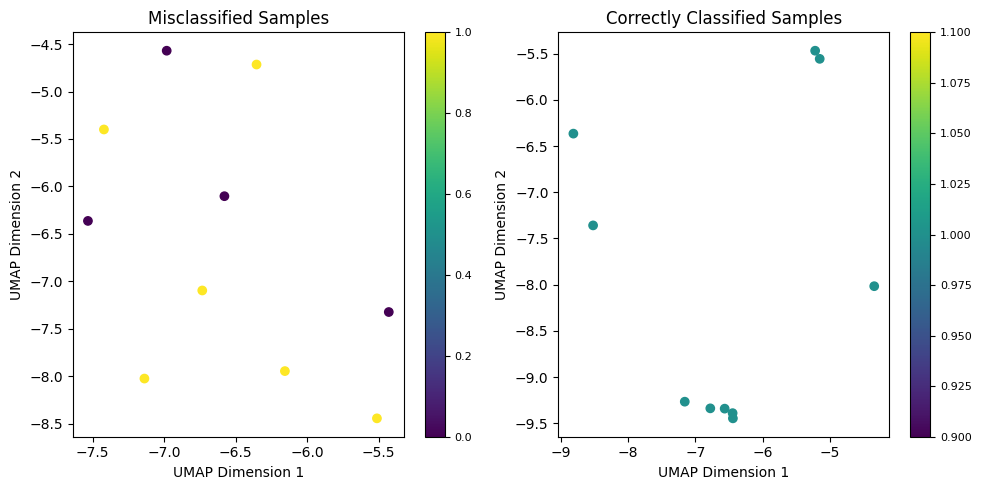

In [28]:
import matplotlib.pyplot as plt
import numpy as np

umap_obj = umap.UMAP(n_neighbors=5, min_dist=0.3, random_state=42)
miss_embedding = umap_obj.fit_transform(miss_data)
right_embedding = umap_obj.transform(right_data)
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

miss_scatter = axs[0].scatter(miss_embedding[:, 0], miss_embedding[:, 1], c=miss_labels)
right_scatter = axs[1].scatter(right_embedding[:, 0], right_embedding[:, 1], c=right_labels)

# Add colorbars to both subplots
for ax, scatter in zip(axs, [miss_scatter, right_scatter]):
    cb = plt.colorbar(scatter, ax=ax)
    cb.ax.tick_params(labelsize=8)

# Set the title and labels for the subplots
axs[0].set_title("Misclassified Samples")
axs[1].set_title("Correctly Classified Samples")
axs[0].set_xlabel("UMAP Dimension 1")
axs[0].set_ylabel("UMAP Dimension 2")
axs[1].set_xlabel("UMAP Dimension 1")
axs[1].set_ylabel("UMAP Dimension 2")

# Adjust spacing between subplots
fig.tight_layout()

# Display the plot
plt.show()
